In [1]:
import numpy as np

import GPyOpt
import GPy

import sys
sys.path.append("..")

from f16lib.acas import AcasShieldScenario, AcasScenario, AcasScenarioViewer

import csaf.utils as csafutils


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import f16lib.models.predictor as predictor

In [2]:
AcasShieldScenario.system_type.components["predictor"].flows["outputs"] = predictor.model_output
AcasShieldScenario.system_type.components["predictor"].initialize = predictor.model_init

In [3]:
from f16lib.components import f16_xequil
import f16lib.systems as f16sys
import csaf
import typing
import numpy as np


In [24]:
def get_system(states, sys=AcasShieldScenario):
    """construct a scenario and system given the configuration coordinates (states)"""
    # scenario
    scen = sys(
        [-2000.0, 6000], # balloon position
        750.0, # ownship airspeed
        ((0.0, 21000.0, 1000.0),), # own waypoints
        ((*states[:2], 1000.0),) # intruder waypoints -- none for now
    )
    # scenario, system
    return scen, scen.create_system(
        [*states[:2], # relative position
         states[2], # relative heading
         states[3]]) # relative airspeed


states = [ 7.81833992e+03,  
        1.59743916e+03, 
        -3.66099248e-01, 
        -8.32456483e+01]

#states = [-7.00317255e+02,
#          7.33473945e+03,
#          2.77626862e+00,
#         -6.73843108e+01]

#states = [ 8.86992784e+03,
#          7.15349648e+03,
#          -1.59055844e+00,
#          -1.24863521e+02]


scen, my_system = get_system(states)

uscen, u_system = get_system(states, sys=AcasScenario)

In [25]:
x, y, z = my_system.components["intruder_autopilot"].default_parameters["waypoints"][0]

In [26]:
my_system.set_component_param("predictor", 
                              "intruder_waypoints",
                             ((x, y, z),))
my_system.set_component_param("predictor", 
                              "own_waypoints",
                             ((0.0, 22000.0, 1000.0),))

In [27]:
my_system.component_instances["predictor"].parameters["own_waypoints"]

((0.0, 22000.0, 1000.0),)

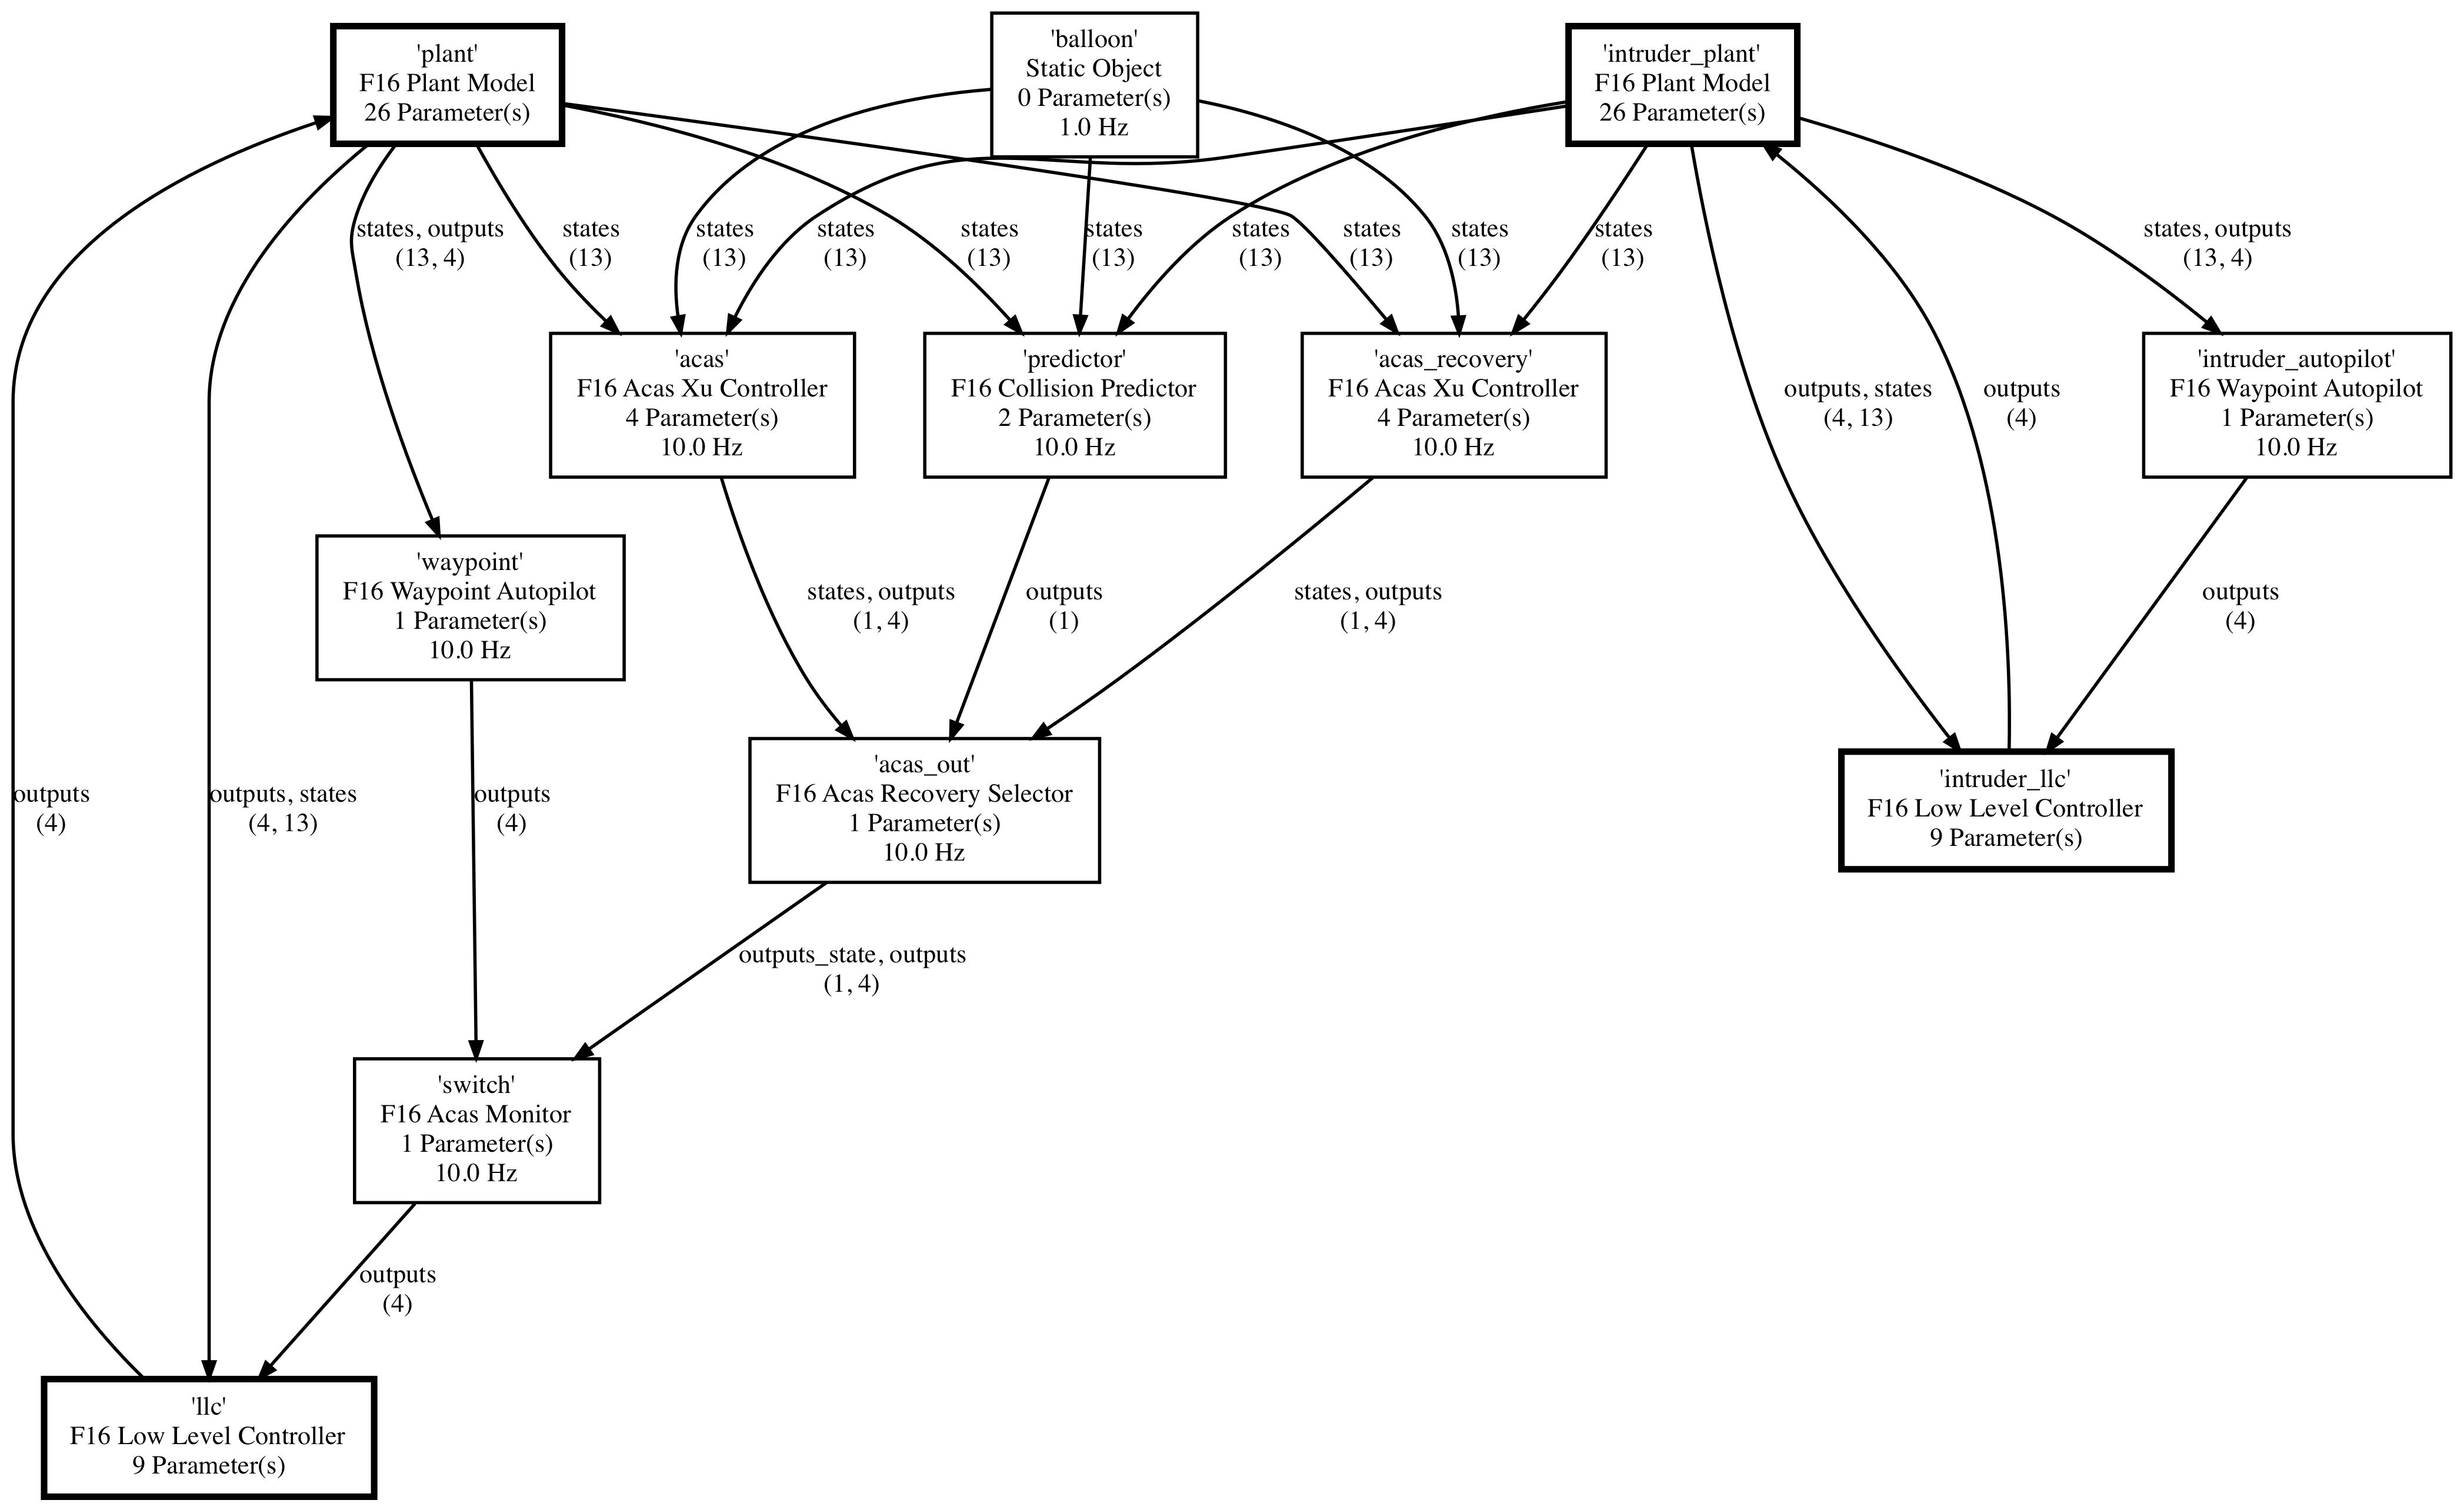

In [28]:
# check the system
my_system.check()

# view the system
csafutils.view_block_diagram(my_system, ipython_notebook=True)

In [29]:
trajs = my_system.simulate_tspan((0.0, 20.0), show_status=True)

100%|██████████████████████████████████████| 3820/3820 [00:17<00:00, 221.34it/s]


In [30]:
def find_peaks_troughs(x):
    def find_trough(idx, x):
        idx += 1
        s = x[idx]
        while x[idx] == s:
            idx += 1
            if idx == len(x):
                break
        return idx - 1
    peaks = [idx for idx in range(len(x)-1) if x[idx] == False and x[idx+1] == True]
    if x[0]:
        peaks += [0]
    troughs = [find_trough(idx, x) for idx in peaks]
    return peaks, troughs


def highlight_axis(ax, x):
    peaks, troughs = find_peaks_troughs(x)
    for peak, trough in zip(peaks, troughs):
        for a in ax:
            a.axvspan(trajs["predictor"].times[peak], trajs["predictor"].times[trough], facecolor='red', alpha=.1)

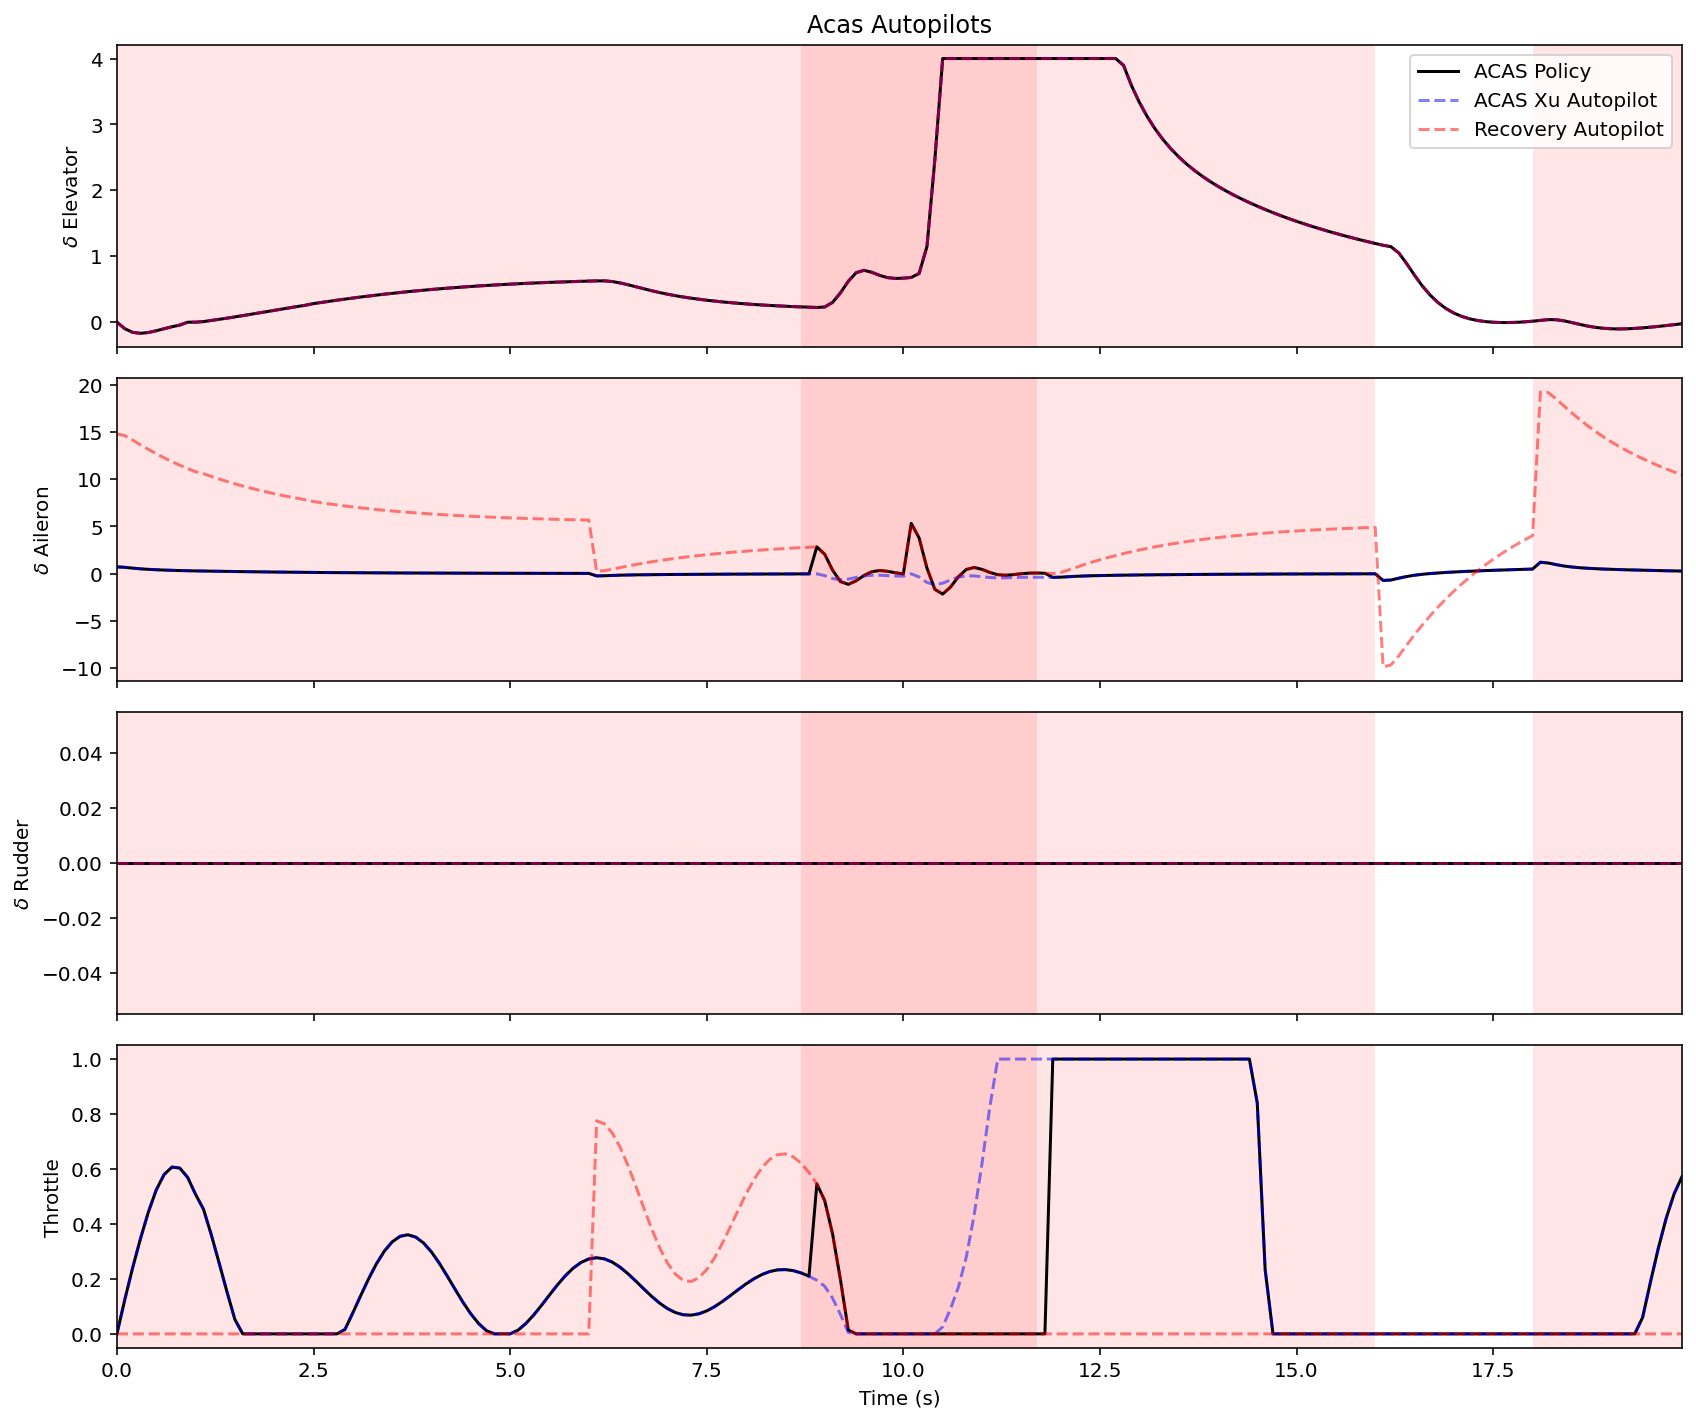

In [31]:
fig, ax = plt.subplots(figsize=(12, 10), nrows=4, sharex=True)

acas = trajs["acas"]
acas_recovery = trajs["acas_recovery"]
acas_out = trajs["acas_out"]

for idx, axi in enumerate(ax):
    axi.plot(np.array(acas_out.times), np.array(acas_out.outputs)[:, idx], 'k', label='ACAS Policy')
    axi.plot(np.array(acas.times), np.array(acas.outputs)[:, idx], '--b', alpha=0.5, label='ACAS Xu Autopilot')
    axi.plot(np.array(acas_recovery.times), np.array(acas_recovery.outputs)[:, idx], '--r', alpha=0.5, label='Recovery Autopilot')

ax[3].set_xlabel("Time (s)")
ax[0].set_title("Acas Autopilots")
ax[0].set_xlim(min(acas.times), max(acas.times))
ax[0].legend()

ax[0].set_ylabel("$\delta$ Elevator")
ax[1].set_ylabel("$\delta$ Aileron")
ax[2].set_ylabel("$\delta$ Rudder")
ax[3].set_ylabel("Throttle")

x = np.array(trajs["predictor"].outputs).flatten()
highlight_axis(ax, x)
        
x = [(True if xi != "clear" else False) for xi in np.array(trajs["acas_out"].outputs_state).flatten()]
highlight_axis(ax, x)
plt.tight_layout()
plt.savefig("acas_policy.png")

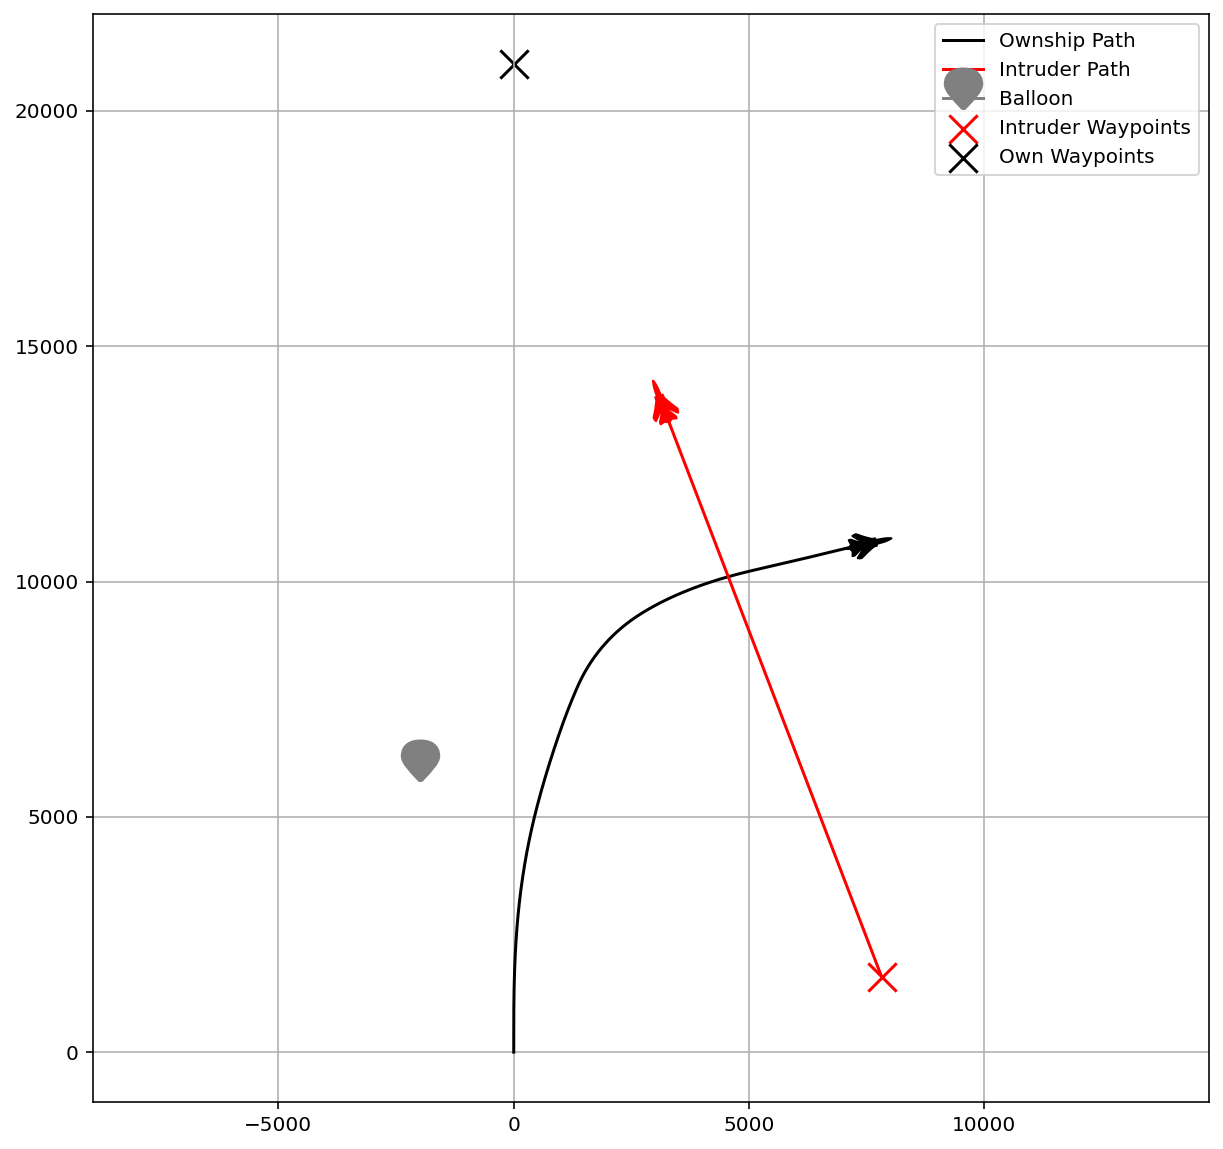

<Figure size 720x720 with 0 Axes>

In [32]:
viewer = AcasScenarioViewer(trajs, scen)
fig, ax = viewer.summary_plot()
plt.show()

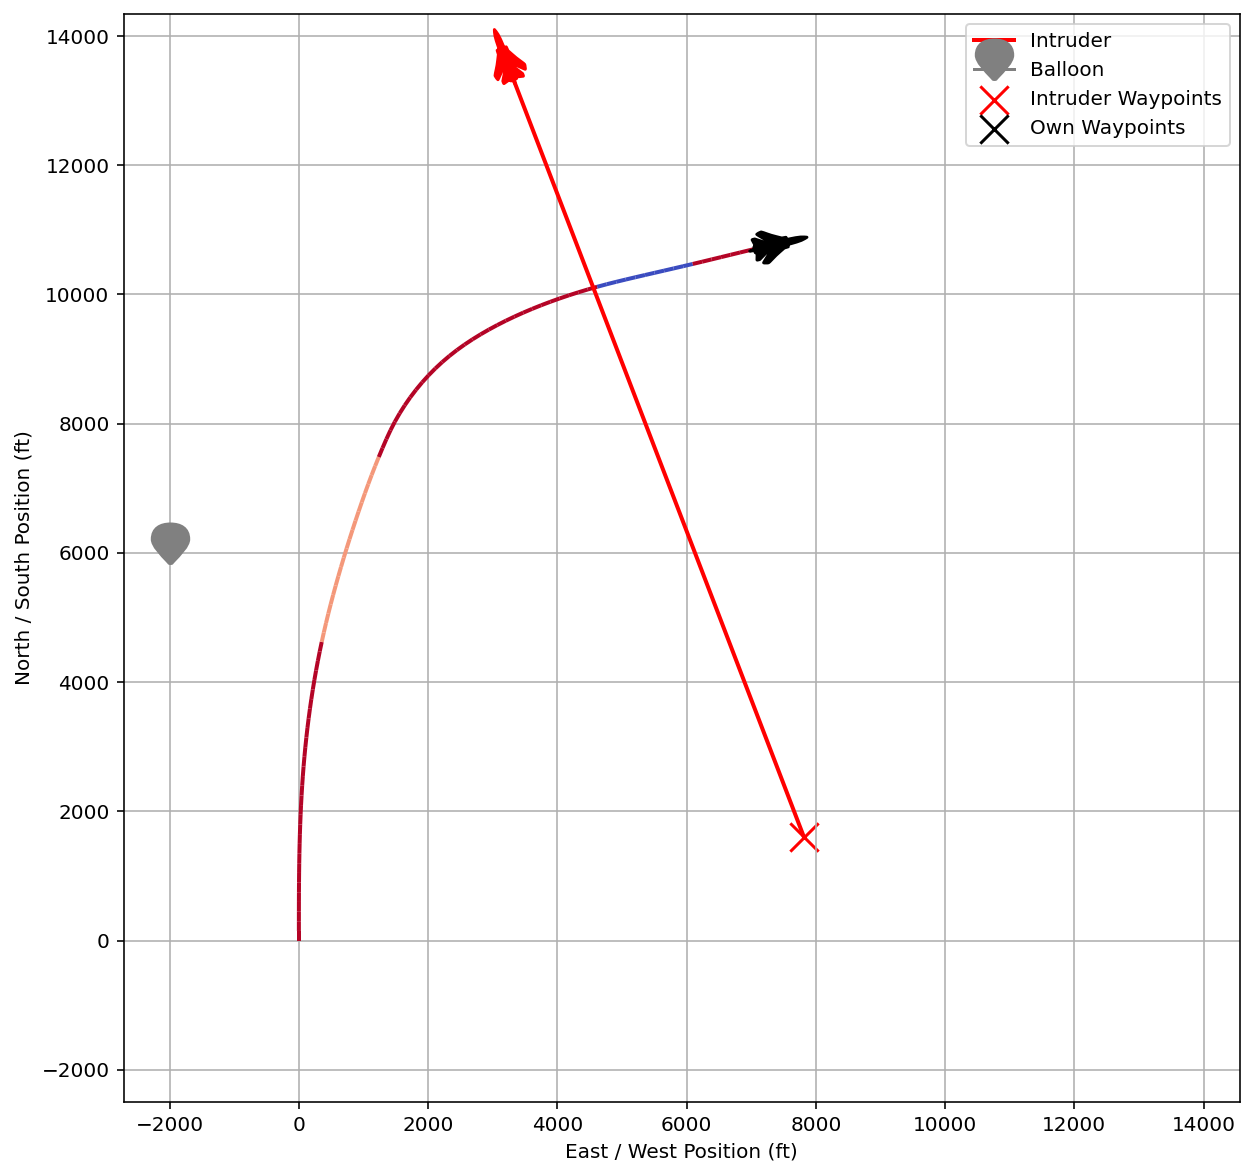

In [33]:
from IPython.display import HTML
from matplotlib import animation
anim = viewer.summary_video()
#writervideo = animation.FFMpegWriter(fps=30) 
#anim.save("bopt_example.mp4", writer=writervideo)
HTML(anim.to_jshtml())